---
format:
  html:
    code-fold: true
execute:
  warning: false
---

# Trends Over Time

## Import Packages and Read Data

In [208]:
library(tidyverse)
library(sf)
library(geojsonsf)
library(leaflet)
library(tmap)
library(spData)
library(usmap)
library(dplyr)
library(ggpubr)

In [209]:
df <- read.csv("../data/cleaned.csv", header = T)
head(df)

,County,GEOID,State,Latitude,Longitude,Location,Year,StateAbbv,Bridges_Bridge.area..square.meters.,Bridges_Bridge.area..fair..square.meters.,...,Person.trips_Trips.1.3.miles,Person.trips_Trips.10.25.miles,Person.trips_Trips.100.250.miles,Person.trips_Trips.25.50.miles,Person.trips_Trips.250.500.miles,Person.trips_Trips.3.5.miles,Person.trips_Trips.5.10.miles,Person.trips_Trips.50.100.miles,Person.trips_Trips.greater.than.or.equal.to.500.miles,Person.trips_Trips.less.than.1.mile
,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2014,SC,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2015,SC,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2016,SC,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2017,SC,64177.63,22864.17,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2018,SC,73924.01,34151.20,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Abbeville County,45001,South Carolina,34.22259,-82.45916,POINT (-82.459165 34.222593),2019,SC,73945.39,35386.65,...,8301866,7936643,105036,2640780,12794,3806550,5149050,690729,80180,6028016


In [210]:
counties <- geojson_sf("../data/us_counties.geojson")

## Trip Frequency Over Time

#### 1. Get the total number of trips in each county for each year

In [211]:
tripFreq <- df[, c(which(colnames(df) %in% c("County","Year","Demographics_Population")), grep("Person.trips", names(df)))]
tripFreq$TotalTrips <- rowSums(tripFreq[, grep("Person.trips", names(tripFreq))])
tripFreq <- tripFreq[, c("County","Year","Demographics_Population","TotalTrips")]
head(tripFreq)

,County,Year,Demographics_Population,TotalTrips
,<chr>,<int>,<dbl>,<dbl>
1,Abbeville County,2014,NA,NA
2,Abbeville County,2015,24997,NA
3,Abbeville County,2016,24951,NA
4,Abbeville County,2017,24788,NA
5,Abbeville County,2018,24657,NA
6,Abbeville County,2019,24627,69503288


#### 2. Fill missing populations and calculate per-capita trips

In [212]:
pops <- tripFreq %>%
  group_by(County) %>%
  summarize(pops = mean(Demographics_Population, na.rm = TRUE))
tripFreq <- tripFreq %>%
  left_join(pops, by = c("County" = "County"))

tripFreq <- tripFreq[complete.cases(tripFreq$TotalTrips), ]
tripFreq$TotalTrips.PerCap <- tripFreq$TotalTrips / tripFreq$pops
tripFreq <- tripFreq[, c("County","Year","TotalTrips.PerCap")]
head(tripFreq)

,County,Year,TotalTrips.PerCap
,<chr>,<int>,<dbl>
6,Abbeville County,2019,2802.100
7,Abbeville County,2020,2329.602
13,Acadia County,2019,2837.425
14,Acadia County,2020,2559.405
20,Accomack County,2019,3661.523
21,Accomack County,2020,2679.957


#### 3. Examine Data

In [213]:
table(tripFreq$Year)


2019 2020 
3138 3141 

#### 4. Plot a choropleth of trip frequency over time

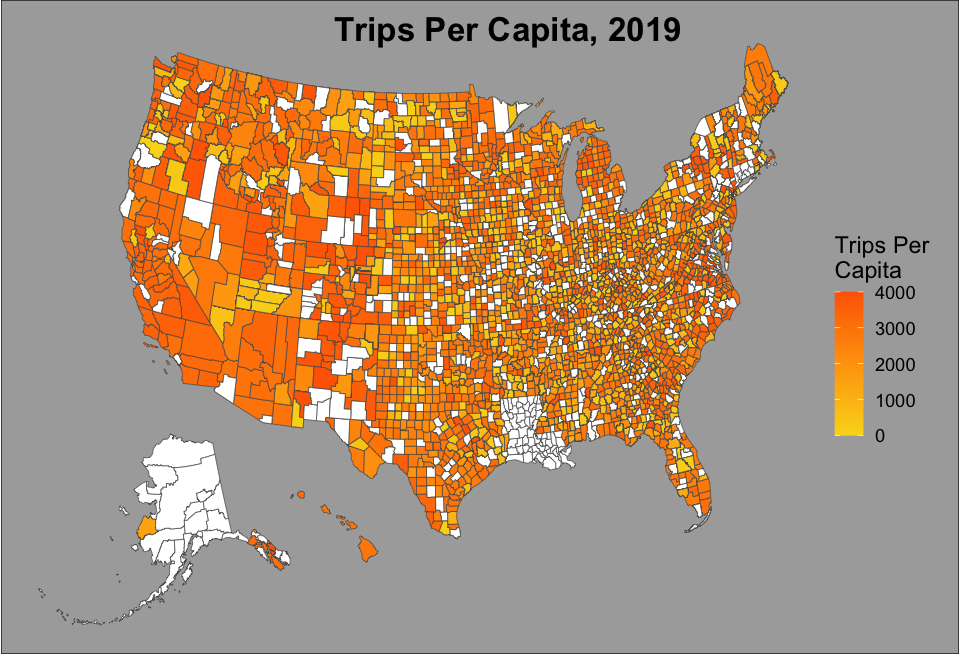

In [230]:
options(
  repr.plot.width = 8,  # Width of the plot in inches
  repr.plot.height = 5.45  # Height of the plot in inches
)

tf.2019 <- tripFreq %>% filter(Year == (2019))
plot.2019 <- ggplot() +
                geom_sf(data = merge(counties, tf.2019, by.x = "county", by.y = "County", all.x = TRUE),
                        aes(fill = TotalTrips.PerCap)) +
                scale_fill_gradient(name = "Trips Per\nCapita", 
                                low = "#F9D71C", high = "#FF6600",na.value = "white",
                                limits = c(0, 4000)) +
                theme_void() +
                theme(legend.position = "right",
                        plot.title = element_text(hjust = 0.7, size = 20, 
                                                face = "bold", color = "black", 
                                                margin = margin(t = 10, b = -20)),  # Adjust font size, face, color, and background of the plot title
                        plot.background = element_rect(fill = "#aaaaaa"),  # Set background color of the plot
                        legend.title = element_text(size = 14),  # Adjust font size of legend title
                        legend.text = element_text(size = 11),
                        legend.margin = margin(t = 0, r = 20, b = 0, l = 0)) + 
                labs(title = "Trips Per Capita, 2019")
plot.2019

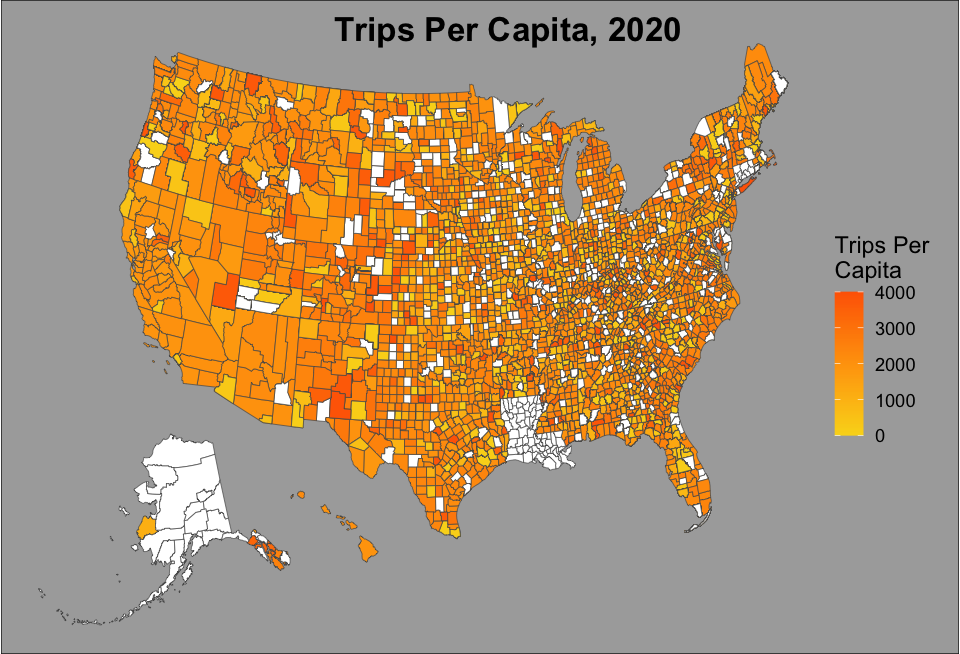

In [229]:
tf.2020 <- tripFreq %>% filter(Year == (2020))
plot.2020 <- ggplot() +
                geom_sf(data = merge(counties, tf.2020, by.x = "county", by.y = "County", all.x = TRUE),
                        aes(fill = TotalTrips.PerCap)) +
                scale_fill_gradient(name = "Trips Per\nCapita", 
                                low = "#F9D71C", high = "#FF6600",na.value = "white",
                                limits = c(0, 4000)) +
                theme_void() +
                theme(legend.position = "right",
                        plot.title = element_text(hjust = 0.7, size = 20, 
                                                face = "bold", color = "black", 
                                                margin = margin(t = 10, b = -20)),  # Adjust font size, face, color, and background of the plot title
                        plot.background = element_rect(fill = "#aaaaaa"),  # Set background color of the plot
                        legend.title = element_text(size = 14),  # Adjust font size of legend title
                        legend.text = element_text(size = 11),
                        legend.margin = margin(t = 0, r = 20, b = 0, l = 0)) + 
                labs(title = "Trips Per Capita, 2020")
plot.2020
# plot.2020 + coord_cartesian(ylim = c(0, 1000 + 5))

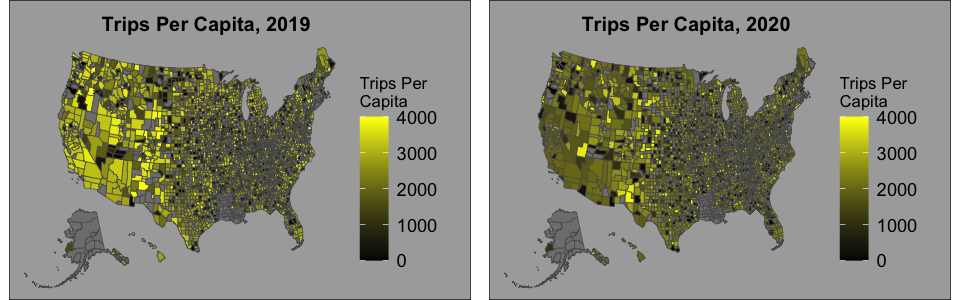

In [216]:
options(
  repr.plot.width = 8,
  repr.plot.height = 2.5
)

ggarrange(plot.2019 +
            theme(plot.title = element_text(hjust = 0.7, size = 12, 
                                            face = "bold", color = "black", 
                                            margin = margin(t = 10, b = -0)),
                  legend.title = element_text(size = 10)),
           plot.2020 +
            theme(plot.title = element_text(hjust = 0.7, size = 12, 
                                            face = "bold", color = "black", 
                                            margin = margin(t = 10, b = -0)),
                  legend.title = element_text(size = 10)),
           ncol = 2)

## Trip Frequency Over Time

In [ ]:
# F9D71C
# FF6600
# white